In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import itertools

# SKLEARN
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import f1_score

# NLP
import re
import string
import html
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

# KERAS / TF
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional, concatenate, \
                         CuDNNLSTM, CuDNNGRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, \
                         Flatten, GRU
from keras.layers.embeddings import Embedding
from keras.callbacks import Callback
print(K.tensorflow_backend._get_available_gpus())

# Flags
balance_dataset = False              # If true, it under-samples the training dataset to get same amount of labels
use_pretrained_embeddings = True     # If true, it enables the use of GloVe pre-trained Twitter word-embeddings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acamb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acamb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# K.tensorflow_backend.

##### ROC AUC & macro-F1 score Printing Callback

In [5]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

class ROC_F1(Callback):
    def __init__(self, validation_data=(), training_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_train, self.y_train = training_data
        self.f1s_train = []
        self.f1s_val = []

        
    def on_epoch_end(self, epoch, logs={}):
        lr = self.model.optimizer.lr
        if self.model.optimizer.initial_decay > 0:
            lr = lr * (1. / (1. + self.model.optimizer.decay * K.cast(self.model.optimizer.iterations, K.dtype(self.model.optimizer.decay))))
        if epoch % self.interval == 0:
            y_pred_train = np.argmax(self.model.predict(self.X_train, verbose=0), axis=1)
            y_pred_val   = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
            
            f1_train = f1_score(self.y_train, y_pred_train, average='macro')
            f1_val   = f1_score(self.y_val, y_pred_val, average='macro')
            
            cm = confusion_matrix(self.y_train, y_pred_train)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            TP_train = np.round(np.diag(cm), decimals=2)
            
            cm = confusion_matrix(self.y_val, y_pred_val)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            TP_val = np.round(np.diag(cm), decimals=2)
            
            self.f1s_val.append(f1_val)
            self.f1s_train.append(f1_train)
            
            print(" - LR: {:0.5f} - train_F1: {:.4f} - val_F1: {:.4f} - train_TP: {} - val_TP: {}".format(K.eval(lr), f1_train, f1_val, TP_train, TP_val))
        if epoch % 1 == 0:
            height = 3.5;    width = height*4
            plt.figure(figsize=(width,height))
            plt.plot(self.f1s_train, label="Train F1")
            plt.plot(self.f1s_val, label="Validation F1")
            plt.xlim([0,50]); plt.xticks(list(range(50)));   plt.grid(True);   plt.legend()
            plt.title("F1-score", fontsize=15)
            plt.show()
        print("\n\n")
        

##### Tweet Processing Function

In [6]:
def process_tweet(tweet, remove_USER_URL=True, remove_punctuation=True, remove_stopwords=True, remove_HTMLentities=True, remove_hashtags=True, appostrophe_handling=True, lemmatize=True, trial=False):
    """
    This function receives tweets and returns clean word-list
    """
    ### Handle USERS and URLS ################################################
    if remove_USER_URL:
        if trial:
            tweet = re.sub(r'@\w+ ?', '', tweet)
            tweet = re.sub(r'http\S+', '', tweet)
        else:
            tweet = re.sub(r"@USER", "<>", tweet)
            tweet = re.sub(r"URL", "", tweet)
    else:
        if trial:
            tweet = re.sub(r'@\w+ ?', '<usertoken> ', tweet)
            tweet = re.sub(r'http\S+', '<urltoken> ', tweet)
        else:
            tweet = re.sub(r"@USER", "<usertoken>", tweet)
            tweet = re.sub(r"URL", "<urltoken>", tweet)
    
    ### Remove HTML Entities #################################################
    if remove_HTMLentities:
        tweet = html.unescape(tweet)
    
    ### REMOVE HASHTAGS? #####################################################
    if remove_hashtags:
        tweet = re.sub(r'#\w+ ?', '', tweet)
    
    ### Convert to lower case: Hi->hi, MAGA -> maga ##########################
    tweet = tweet.lower()
    
    ### Cleaning: non-ASCII filtering, some appostrophes, separation #########
    tweet = re.sub(r"’", r"'", tweet)
    tweet = re.sub(r"[^A-Za-z0-9'^,!.\/+-=@]", " ", tweet)
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
#     tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", " ! ", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ^ ", tweet)
    tweet = re.sub(r"\+", " + ", tweet)
    tweet = re.sub(r"\-", " - ", tweet)
    tweet = re.sub(r"\=", " = ", tweet)
    tweet = re.sub(r"(\d+)(k)", r"\g<1>000", tweet)
    tweet = re.sub(r":", " : ", tweet)
    tweet = re.sub(r" e g ", " eg ", tweet)
    tweet = re.sub(r" b g ", " bg ", tweet)
    tweet = re.sub(r" u s ", " american ", tweet)
    tweet = re.sub(r"\0s", "0", tweet)
    tweet = re.sub(r" 9 11 ", "911", tweet)
    tweet = re.sub(r"e - mail", "email", tweet)
    tweet = re.sub(r"j k", "jk", tweet)
    tweet = re.sub(r"\s{2,}", " ", tweet)

    ### Remove Punctuation ###################################################
    if remove_punctuation:
        translator = str.maketrans('', '', ''.join(list(set(string.punctuation) - set("'"))))
        tweet = tweet.translate(translator)
    
    # Tokenize sentence for further word-level processing
    tokenizer  = TweetTokenizer()
    words = tokenizer.tokenize(tweet)
    
    ### Apostrophe handling:    you're   -> you are  ########################
    APPO = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would", "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"}
    if appostrophe_handling:
        words = [APPO[word] if word in APPO else word for word in words]
    
    tweet = ' '.join(words)
    words = tokenizer.tokenize(tweet)
    
    ### Convert to lower case: Hi->hi, MAGA -> maga ##########################
    
    ### Lemmatisation:          drinking -> drink ###########################
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word, "v") for word in words]
    
    ### Remove stop words:      is, that, the, ... ##########################
    if remove_stopwords:
        eng_stopwords = set(stopwords.words("english"))
        words = [w for w in words if not w in eng_stopwords]
        
    clean_tweet = " ".join(words)
    clean_tweet = re.sub("  "," ",clean_tweet)
    clean_tweet = clean_tweet.lower()
    
    return clean_tweet

In [7]:
from random import shuffle

def under_sample(X, y):
    idx_0 = np.where(y==0)[0].tolist()
    idx_1 = np.where(y==1)[0].tolist()

    N = np.min([len(idx_0), len(idx_1)])
    idx = idx_0[:N] + idx_1[:N]
    shuffle(idx)
    
    X = X[idx].reshape(-1)
    y = y[idx].reshape(-1,1)
    
    return X, y

## 1. LOAD DATA AND PRE-PROCESS

In [8]:
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_c = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')
# whole_corpus_clean = df_c['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values
df_c = df_c[pd.notnull(df_c['subtask_c'])].reset_index(drop=True)
display(df_c['subtask_c'].unique())

df_c_trial = pd.read_csv('../OffensEval_data/trial/offenseval-trial.txt', sep='\t')
df_c_trial = df_c_trial[pd.notnull(df_c_trial['subtask_c'])].reset_index(drop=True)
df_c_trial = df_c_trial[df_c_trial['subtask_c'] != 'ORG']
display(df_c_trial['subtask_c'].unique())

array(['IND', 'OTH', 'GRP'], dtype=object)

array(['IND', 'GRP', 'OTH'], dtype=object)

In [9]:
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_c = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')
whole_corpus_clean = df_c['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values
df_c = df_c[pd.notnull(df_c['subtask_c'])].reset_index(drop=True)

df_c_trial = pd.read_csv('../OffensEval_data/trial/offenseval-trial.txt', sep='\t')
df_c_trial = df_c_trial[pd.notnull(df_c_trial['subtask_c'])].reset_index(drop=True)
df_c_trial = df_c_trial[df_c_trial['subtask_c'] != 'ORG']

X = df_c['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values
y = df_c['subtask_c'].replace({'IND': 0, 'GRP': 1, 'OTH': 2}).values.reshape(-1,1)
ohe = OneHotEncoder(categories='auto')
Y = ohe.fit_transform(y).toarray()

X_trial = df_c_trial['tweet'].apply(lambda x: process_tweet(x, **params, trial=True)).values;
y_trial = df_c_trial['subtask_c'].replace({'IND': 0, 'GRP': 1, 'OTH': 2}).values.reshape(-1,1)
ohe = OneHotEncoder(categories='auto')
Y_trial = ohe.fit_transform(y_trial).toarray()

class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.reshape(-1))
print(class_weights)
if balance_dataset:
    X, y = under_sample(X, y)


print("EXAMPLES OF PROCESSED TWEETS [train/trial]")
print("_________________________________________________________________________________________________________")
for id in range(4):
    print("Un-processed:  " + df_c['tweet'][id])
    print("Processed:     " + X[id])
    print("")
print("_________________________________________________________________________________________________________")
for id in range(4):
    print("Un-processed:  " + df_c_trial['tweet'][id])
    print("Processed:     " + X_trial[id])
    print("")

[0.53676776 1.20297952 3.27088608]
EXAMPLES OF PROCESSED TWEETS [train/trial]
_________________________________________________________________________________________________________
Un-processed:  @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
Processed:     go home you be drink

Un-processed:  @USER Liberals are all Kookoo !!!
Processed:     liberals be all kookoo

Un-processed:  @USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism
Processed:     be literally just talk about this lol all mass shoot like that have be set up it propaganda use to divide us on major issue like gun control and terrorism

Un-processed:  @USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo
Processed:     canada do not need another cuck we already have enough f king up our great c

In [8]:
# params = dict(remove_USER_URL=True,
#               remove_stopwords=False,
#               remove_HTMLentities=True,
#               remove_punctuation=True,
#               appostrophe_handling=True,
#               lemmatize=True)

# # TRAINING SET ----------------------------------------------------------------------------------------------------------
# tweets_train = train_df['tweet'];
# clean_tweets_train = tweets_train.apply(lambda x: process_tweet(x, **params, trial=False)).values

# df_a = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')
# df_b = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')
# df_c = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')

# df_a['subtask_a'] = df_a['subtask_a'].replace({'OFF': 1, 'NOT': 0})

# # Binarize labels ('OFF -> 1', 'NOT' -> 0) and print stats
# y_a = df_a['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;
# y_b = train_df['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;
# y_c = train_df['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;

# # Assign weights to each class to deal with imbalance of dataset (penalizes the loss function based on sample support)
# class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.reshape(-1))

# # BALANCE (Under-sample dataset)
# if balance_dataset:
#     tweets_train()
# # -----------------------------------------------------------------------------------------------------------------------

# # TRIAL (VAL) SET -------------------------------------------------------------------------------------------------------
# trial_df = pd.read_csv('../OffensEval_data/trial/offenseval-trial.txt', sep='\t')

# tweets_trial = trial_df['tweet'];
# labels_trial = trial_df['subtask_a'];

# # Process all tweets
# clean_tweets_trial = tweets_trial.apply(lambda x: process_tweet(x, **params, trial=True)).values

# # Binarize labels ('OFF -> 1', 'NOT' -> 0) and print stats
# y_trial = labels_trial.replace({'OFF': 1, 'NOT': 0}).values
# labs, counts = np.unique(y_trial, return_counts=True)
# print("\n\nTrial Set:\nLabel   Count   Percentage")
# for label, count in zip(labs, counts):
#     print("{}         {}    {:0.2f}%".format(label, count, count/len(y_trial)*100))
# #------------------------------------------------------------------------------------------------------------------------

# print("\n\nEXAMPLES OF PROCESSED TWEETS [train/trial]"
# print("_________________________________________________________________________________________________________")
# for id in range(4):
#     print("Un-processed:  " + tweets_train[id])
#     print("Processed:     " + clean_tweets_train[id])
#     print("")
# print("_________________________________________________________________________________________________________")
# for id in range(4):
#     print("Un-processed:  " + tweets_trial[id])
#     print("Processed:     " + clean_tweets_trial[id])
#     print("")

#### Build Vocabulary by Hand (Not of any actual use, only to print size and unique word count)

In [9]:
def get_tokenized_corpus(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        tokenized_sentence = []
        for token in sentence.split(' '): 
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)
    return tokenized_corpus


tokenized_corpus = get_tokenized_corpus(X)
tokenized_corpus

vocabulary = []
token_count = 0
for sentence in tokenized_corpus:
    for token in sentence:
        token_count += 1
        if token not in vocabulary:
            vocabulary.append(token)
            
print("This corpus contains {} tokens, of which {} are unique. I.e. avg of {:0.2f} words per tweet.".format(token_count, len(vocabulary), token_count/X.shape[0]))

This corpus contains 85364 tokens, of which 7592 are unique. I.e. avg of 22.02 words per tweet.


## Prepare Data for Model
#### Tokenize tweets  |  Turn into Index sequences  |  Pad sequences to max_length  |  (optional) Use word embeddings

##### GloVe Twitter word-embedding how to:
1. Read embeddings and build a [word -> vector] dictionary
2. Use tokenizer [word -> index] dictionary to iterate through all words in vocab
3. For each word in vocab (iterate over [word -> index] tokenizer dictionary): 
    - Attempt to get word's embedding vector from GloVe Twitter [word -> vector]
    - If word is in embedding's vocabulary: add the vector to the embedding matrix at the right index
    - If not, do not do anything (respective vector will be [0, 0, 0, ..., 0]

Embedding matrix will be of size (nb_words + 1, embedding_dim), this will be loaded into the embeddings layer later

In [10]:
####################################################################################################
##   BUILD VOCABULARY FROM CORPUS   ################################################################
####################################################################################################
max_seq_len    = 55
max_features   = 30000

# Tokenize all tweets
tokenizer = Tokenizer(lower=True, filters='', split=' ')
X_all = list(whole_corpus_clean) + list(X_trial)
tokenizer.fit_on_texts(X_all)
print(f"Num of unique tokens in tokenizer: {len(tokenizer.word_index)}")

# Get sequences for each dataset
sequences       = tokenizer.texts_to_sequences(X)
sequences_trial = tokenizer.texts_to_sequences(X_trial)

# Pad sequences
X       = pad_sequences(sequences, maxlen = max_seq_len)
X_trial = pad_sequences(sequences_trial, maxlen = max_seq_len)

# Reshape labels
y       = y.reshape(-1,1)
y_trial = y_trial.reshape(-1,1)

####################################################################################################
##   GloVe EMBEDDINGS     ##########################################################################
####################################################################################################
if use_pretrained_embeddings:
    # Download embeddings from https://nlp.stanford.edu/projects/glove/
    #                          https://nlp.stanford.edu/data/glove.twitter.27B.zip
    embedding_path = "glove.twitter.27B.100d.txt"
    embed_size     = 100
    
    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    # Construct embedding table (word -> vector)
    print("Building embedding index [word->vector]", end="")
    t0 = time.time()
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))
    print(" - Done! ({:0.2f}s)".format(time.time()-t0))

    # Build Embedding Matrix

    words_in_glove = 0
    words_not_in_glove = 0
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    print(f"Building embedding matrix {embedding_matrix.shape}", end="")
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_in_glove += 1
        else:
            words_not_in_glove += 1
    print(" - Done!")
    print("This vocabulary has {} unique tokens of which {} are in the embeddings and {} are not".format(len(word_index), words_in_glove, words_not_in_glove))

Num of unique tokens in tokenizer: 14591
Building embedding index [word->vector] - Done! (44.14s)
Building embedding matrix (14592, 100) - Done!
This vocabulary has 14591 unique tokens of which 12740 are in the embeddings and 1851 are not


Mean sentence length: 22.0 words
MAX  sentence length: 62 words


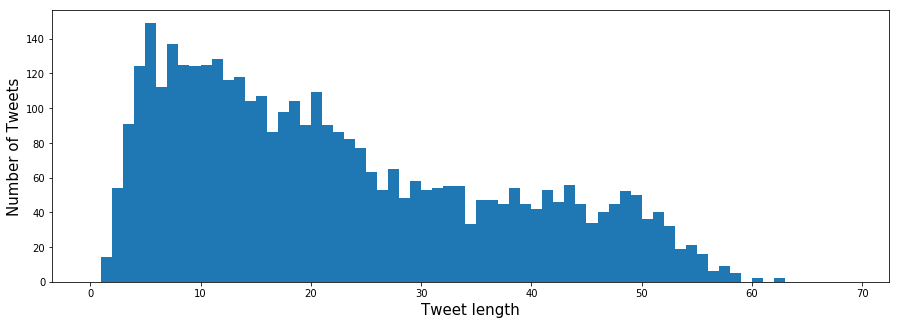

In [11]:
sentence_lengths = [len(tokens) for tokens in sequences]
print("Mean sentence length: {:0.1f} words".format(np.mean(sentence_lengths)))
print("MAX  sentence length: {} words".format(np.max(sentence_lengths)))

fig = plt.figure(figsize=(15, 5)) 
plt.xlabel('Tweet length', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.hist(sentence_lengths, bins=list(range(70)))
plt.show()

# 2. BUILD MODEL & TRAIN

### Define RNN Models

In [12]:
def build_Bi_GRU_LSTM_CN_model(lr=0.001, lr_decay=0.01, recurrent_units=0, dropout=0.0):
    # Model architecture
    inputs = Input(shape = (max_seq_len,), name="Input")
    
    emb = Embedding(nb_words+1, embed_size, trainable=train_embeddings, name="WordEmbeddings")(inputs)
    emb = SpatialDropout1D(dropout)(emb)

    gru_out  = Bidirectional(CuDNNGRU(recurrent_units, return_sequences = True), name="Bi_GRU")(emb)
    gru_out  = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(gru_out)

    lstm_out = Bidirectional(CuDNNLSTM(recurrent_units, return_sequences = True), name="Bi_LSTM")(emb)
    lstm_out = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(lstm_out)

    avg_pool1 = GlobalAveragePooling1D(name="GlobalAVGPooling_GRU")(gru_out)
    max_pool1 = GlobalMaxPooling1D(name="GlobalMAXPooling_GRU")(gru_out)

    avg_pool2 = GlobalAveragePooling1D(name="GlobalAVGPooling_LSTM")(lstm_out)
    max_pool2 = GlobalMaxPooling1D(name="GlobalMAXPooling_LSTM")(lstm_out) 

    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    outputs = Dense(3, activation='softmax', name="Output")(x)
    
    model = Model(inputs,outputs)
    
    return model, 1

def build_LSTM():
    model = Sequential()
    model.add(Embedding(nb_words+1, embed_size, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Bidirectional(CuDNNLSTM(RECURRENT_UNITS)))
    model.add(Dense(3, activation='softmax'))
    
    return model, 0

def build_CNN_LSTM():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Conv1D(64, 4, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Dense(3, activation='softmax'))
    
    return model, 0

def build_LSTM_CNN():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
#     model.add(SpatialDropout1D(DROPOUT))
    model.add(Dropout(DROPOUT))
    model.add(Bidirectional(CuDNNLSTM(EMBEDDING_DIM, return_sequences=True)))
#     model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Conv1D(64, kernel_size=2, activation='relu', padding='valid', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    return model, 0

### Build and Train

[0.0004, 0.0, 30, 32, 100, 0.5, 0.0]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embeddings (Embedding)       (None, 55, 100)           1459200   
_________________________________________________________________
spatial_dropout1d_28 (Spatia (None, 55, 100)           0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 60)                31680     
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 183       
Total params: 1,491,063
Trainable params: 31,863
Non-trainable params: 1,459,200
_________________________________________________________________
Class weights (to address dataset imbalance)


{0: 0.5367965367965368, 1: 1.2029491656965463, 2: 3.270042194092827}

Train on 3876 samples, validate on 36 samples
Epoch 1/30
3876/3876 [==============================] - 4s 1ms/step - loss: 0.6292 - acc: 0.6689 - val_loss: 0.6193 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 0.61929, saving model to weights-improvement-01-0.66667-0.61929.hdf5
 - LR: 0.00040 - train_F1: 0.4457 - val_F1: 0.2735 - train_TP: [0.66 0.4  0.33] - val_TP: [0.57 0.   0.5 ]


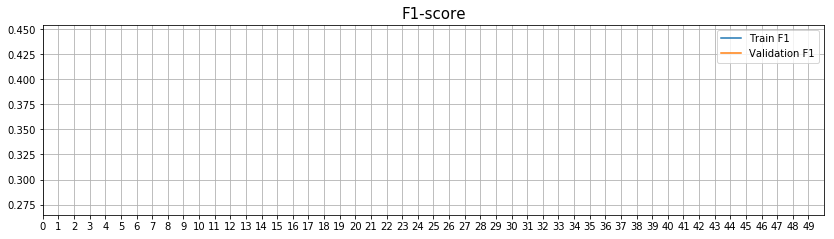




Epoch 2/30
3876/3876 [==============================] - 2s 485us/step - loss: 0.6148 - acc: 0.6809 - val_loss: 0.6141 - val_acc: 0.6667

Epoch 00002: val_loss improved from 0.61929 to 0.61407, saving model to weights-improvement-02-0.66667-0.61407.hdf5
 - LR: 0.00040 - train_F1: 0.4810 - val_F1: 0.3898 - train_TP: [0.65 0.64 0.2 ] - val_TP: [0.63 0.25 0.5 ]


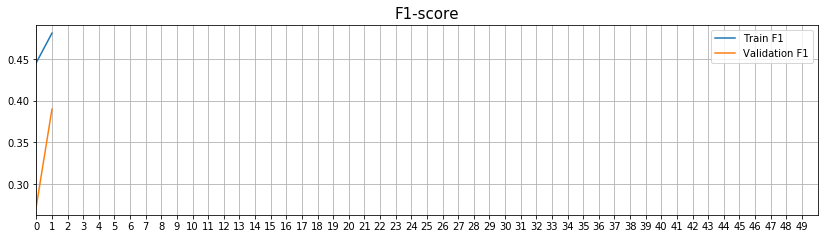




Epoch 3/30
3876/3876 [==============================] - 2s 512us/step - loss: 0.5970 - acc: 0.7195 - val_loss: 0.5425 - val_acc: 0.7778

Epoch 00003: val_loss improved from 0.61407 to 0.54255, saving model to weights-improvement-03-0.77778-0.54255.hdf5
 - LR: 0.00040 - train_F1: 0.4788 - val_F1: 0.5244 - train_TP: [0.73 0.71 0.06] - val_TP: [0.7  0.25 0.5 ]


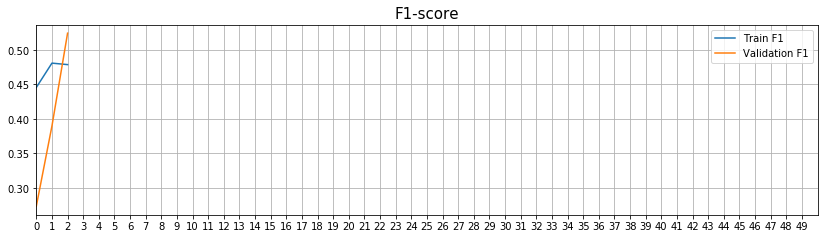




Epoch 4/30
3876/3876 [==============================] - 2s 521us/step - loss: 0.5805 - acc: 0.7488 - val_loss: 0.4653 - val_acc: 0.8333

Epoch 00004: val_loss improved from 0.54255 to 0.46533, saving model to weights-improvement-04-0.83333-0.46533.hdf5
 - LR: 0.00040 - train_F1: 0.5177 - val_F1: 0.4992 - train_TP: [0.79 0.64 0.14] - val_TP: [0.83 0.25 0.5 ]


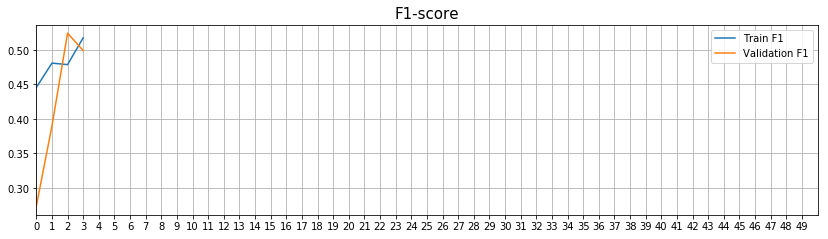




Epoch 5/30
3876/3876 [==============================] - 2s 498us/step - loss: 0.5746 - acc: 0.7542 - val_loss: 0.4500 - val_acc: 0.8241

Epoch 00005: val_loss improved from 0.46533 to 0.45001, saving model to weights-improvement-05-0.82407-0.45001.hdf5
 - LR: 0.00040 - train_F1: 0.5370 - val_F1: 0.5175 - train_TP: [0.78 0.67 0.17] - val_TP: [0.87 0.25 0.5 ]


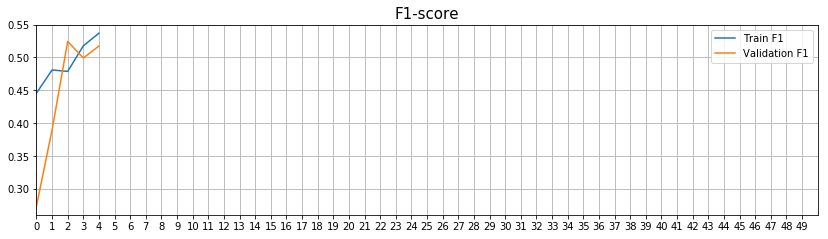




Epoch 6/30
3876/3876 [==============================] - 2s 499us/step - loss: 0.5699 - acc: 0.7565 - val_loss: 0.4639 - val_acc: 0.8056

Epoch 00006: val_loss did not improve from 0.45001
 - LR: 0.00040 - train_F1: 0.5502 - val_F1: 0.4818 - train_TP: [0.75 0.69 0.24] - val_TP: [0.83 0.25 0.5 ]


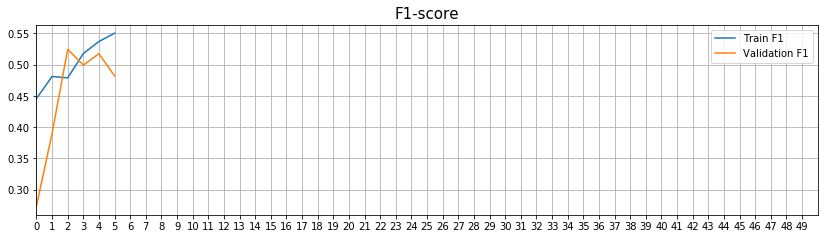




Epoch 7/30
3876/3876 [==============================] - 2s 481us/step - loss: 0.5646 - acc: 0.7620 - val_loss: 0.5210 - val_acc: 0.7870

Epoch 00007: val_loss did not improve from 0.45001
 - LR: 0.00040 - train_F1: 0.5385 - val_F1: 0.4990 - train_TP: [0.69 0.8  0.19] - val_TP: [0.73 0.5  0.5 ]


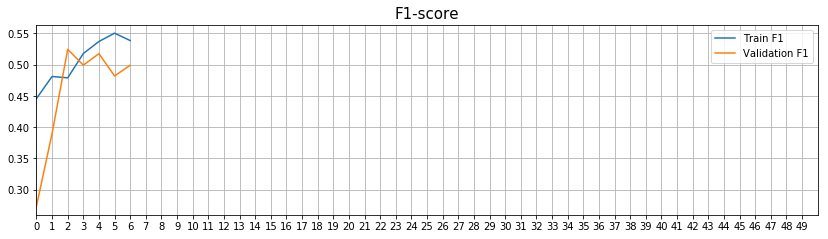




Epoch 8/30
3876/3876 [==============================] - 2s 501us/step - loss: 0.5655 - acc: 0.7571 - val_loss: 0.4602 - val_acc: 0.7963

Epoch 00008: val_loss did not improve from 0.45001
 - LR: 0.00040 - train_F1: 0.5534 - val_F1: 0.4818 - train_TP: [0.75 0.76 0.19] - val_TP: [0.83 0.25 0.5 ]


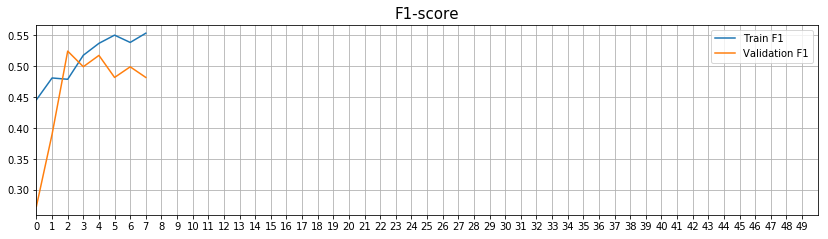




Epoch 9/30
3876/3876 [==============================] - 4s 972us/step - loss: 0.5560 - acc: 0.7695 - val_loss: 0.4974 - val_acc: 0.7963

Epoch 00009: val_loss did not improve from 0.45001
 - LR: 0.00040 - train_F1: 0.5655 - val_F1: 0.4405 - train_TP: [0.71 0.74 0.32] - val_TP: [0.77 0.25 0.5 ]


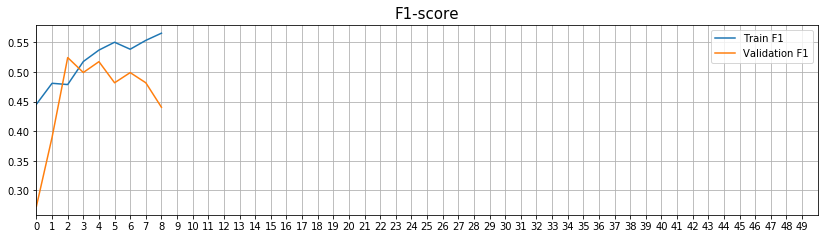




Epoch 10/30
2976/3876 [======================>.......] - ETA: 1s - loss: 0.5523 - acc: 0.7593

KeyboardInterrupt: 

In [58]:
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# SET HYPERPARAMETERS -------------------------------------------------------------------------------------------
LR               = 0.0004
LR_DECAY         = 0.00
EPOCHS           = 30
BATCH_SIZE       = 32
EMBEDDING_DIM    = embed_size
DROPOUT          = 0.5         # Connection drop ratio for CNN to LSTM dropout
LSTM_DROPOUT     = 0.0         # Connection drop ratio for gate-specific dropout
BIDIRECTIONAL    = True
RECURRENT_UNITS  = 30
train_embeddings = not use_pretrained_embeddings
print([LR, LR_DECAY, EPOCHS, BATCH_SIZE, EMBEDDING_DIM, DROPOUT, LSTM_DROPOUT])
#---------------------------------------------------------------------------------------------------------------


# BUILD MODEL --------------------------------------------------------------------------------------------------
# - Can select which architecture to use (simple LSTM works pretty well)
model, embed_idx = build_LSTM()
# model, embed_idx = build_CNN_LSTM()
# model, embed_idx = build_LSTM_CNN()
# model, embed_idx = build_Bi_GRU_LSTM_CN_model(LR, LR_DECAY, embed_size, DROPOUT)
#---------------------------------------------------------------------------------------------------------------


# OPTIMIZER | COMPILE | EMBEDDINGS -----------------------------------------------------------------------------
optim = optimizers.Adam(lr=LR, decay=LR_DECAY)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
if use_pretrained_embeddings:
    model.layers[embed_idx].set_weights([embedding_matrix])
model.summary()
#---------------------------------------------------------------------------------------------------------------
# X_train, X_val, y_train, y_val = (X, y, X_trial, Y_trial)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X, Y, y, test_size=0.2, stratify=y)
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.reshape(-1))
weights_dict = dict()
for i, weight in enumerate(class_weights):
    weights_dict[i] = weight
print("Class weights (to address dataset imbalance)")
display(weights_dict)


# Can change right hand side to (X, Y, X_trial, Y_trial) or (X_train, Y_train, X_val, Y_val)
X_train, Y_train, y_train, X_val, Y_val, y_val = (X, Y, y, X_trial, Y_trial, y_trial)

# FIT THE MODEL ------------------------------------------------------------------------------------------------
auc_f1     =  ROC_F1(validation_data=(X_trial, y_trial), training_data=(X_train, y_train), interval=1)
earlystop  =  EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto', restore_best_weights=True)
filepath   =  "weights-improvement-{epoch:02d}-{val_acc:.5f}-{val_loss:.5f}.hdf5"
checkpoint =  ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, mode='min')

train_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), class_weight=weights_dict, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          verbose=1, callbacks=[earlystop, checkpoint, auc_f1])
# # #---------------------------------------------------------------------------------------------------------------

In [31]:
from keras.models import load_model
model.save('TASK_C_LSTM.h5')
loaded_model = load_model('TASK_C_LSTM.h5')

### Evaluate [Training History, Classification Report + Metrics]


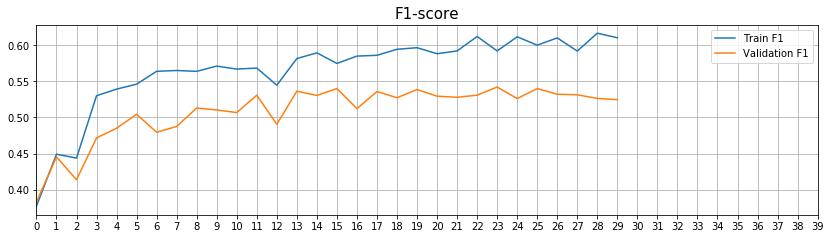

array([[0.68672734, 0.0990067 , 0.21426602],
       [0.0864087 , 0.5814923 , 0.33209896],
       [0.09657075, 0.18262857, 0.7208007 ],
       ...,
       [0.14119267, 0.46416208, 0.3946453 ],
       [0.20204818, 0.25759333, 0.5403585 ],
       [0.32000852, 0.11372364, 0.56626785]], dtype=float32)

(array([0, 1, 2], dtype=int64), array([2079,  915,  882], dtype=int64))

Validation Accuracy: 68.29%
Normalized confusion matrix


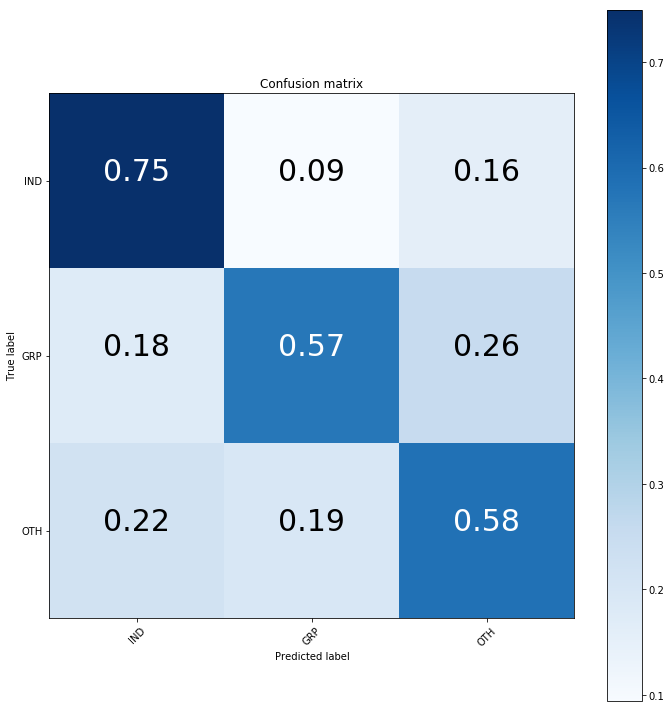

[[1804  226  377]
 [ 188  612  274]
 [  87   77  231]]
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      2407
           1       0.67      0.57      0.62      1074
           2       0.26      0.58      0.36       395

   micro avg       0.68      0.68      0.68      3876
   macro avg       0.60      0.63      0.59      3876
weighted avg       0.75      0.68      0.71      3876



In [39]:
height = 3.5;    width = height*4
n_epochs = 40
# n_epochs = len(train_history.history['loss'])

# # Plot Loss
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['loss'], label="Train Loss")
# plt.plot(train_history.history['val_loss'], label="Validation Loss")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Loss (Binary Cross-entropy)", fontsize=15)
# plt.show()

# # Plot accuracy
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['acc'], label="Train Accuracy")
# plt.plot(train_history.history['val_acc'], label="Validation Accuracy")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Accuracy", fontsize=15)
# plt.show()

# Plot F1
plt.figure(figsize=(width,height))
plt.plot(auc_f1.f1s_train, label="Train F1")
plt.plot(auc_f1.f1s_val, label="Validation F1")
plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
plt.title("F1-score", fontsize=15)
plt.show()


##### Confusion matrix & Classication Report ###################################################
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

X_eval = X
y_eval = y

y_pred = model.predict(X_eval)
y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)
display(np.unique(y_pred, return_counts=True))
print("Validation Accuracy: {:0.2f}%".format(np.sum(y_eval==y_pred)/y_eval.shape[0]*100))

cm = confusion_matrix(y_eval, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['IND','GRP', 'OTH'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)


from sklearn.metrics import classification_report
print(classification_report(y_eval, y_pred))

## Generate Submission

In [12]:
from keras.models import load_model
model = load_model("model_C.h5")
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_test = pd.read_csv('../OffensEval_data/test/test_set_taskc.tsv',sep='\t')
ID = df_test['id']

X_test = df_test['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values

sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen = max_seq_len)

X_test.shape

Y_pred = model.predict(X_test)
# y_pred = np.array([0.6, 0.3, 0.2, 0.7]).reshape(-1,1)
display(Y_pred)

classes = np.argmax(Y_pred, axis=1).reshape(-1,1)
display(classes.shape)

df_submission = pd.DataFrame()
df_submission['id'] = ID
df_submission['label'] = classes
df_submission['label'] = df_submission['label'].replace({0: 'IND', 1: 'GRP', 2: 'OTH'})
df_submission.head()
df_submission.to_csv("submission_c/test_c_submission.csv", header=None, index=None)

array([[0.03312751, 0.33906198, 0.6278105 ],
       [0.12216339, 0.31867164, 0.55916494],
       [0.58210313, 0.06761082, 0.3502861 ],
       [0.88498443, 0.04752984, 0.06748574],
       [0.88499093, 0.02619039, 0.08881866],
       [0.61717147, 0.15621927, 0.22660929],
       [0.35042155, 0.27476373, 0.37481475],
       [0.74616224, 0.04760157, 0.20623617],
       [0.6315786 , 0.11485177, 0.25356963],
       [0.92747325, 0.01976245, 0.05276426],
       [0.13984713, 0.1547026 , 0.7054503 ],
       [0.911203  , 0.02568457, 0.06311237],
       [0.1005515 , 0.32720765, 0.5722408 ],
       [0.4534931 , 0.19886215, 0.34764478],
       [0.09481548, 0.68201804, 0.22316644],
       [0.743002  , 0.07573733, 0.18126065],
       [0.03642835, 0.8501375 , 0.11343419],
       [0.19447967, 0.09283066, 0.71268964],
       [0.05146604, 0.6107441 , 0.33778992],
       [0.12955882, 0.33124584, 0.53919536],
       [0.2610229 , 0.3319998 , 0.40697727],
       [0.6193233 , 0.10157055, 0.2791062 ],
       [0.

(213, 1)

In [ ]:
# TO USE TWITTER GLOVE EMBEDDINGS ##########################
# https://nlp.stanford.edu/projects/glove/
# https://nlp.stanford.edu/data/glove.twitter.27B.zip

# PRE-PROCESS
import re
def glove_preprocess(text):
    """
    adapted from https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
    """
    # Different regex parts for smiley faces
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r'http\S+', '<URL> ', text)
    text = re.sub(r'@\S+', '<USER>', text)
    text = re.sub("www.* ", "<URL>", text)
    text = re.sub("\[\[User(.*)\|", '<USER>', text)
    text = re.sub("<3", r'<HEART> ', text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub(eyes + nose + "[Dd)]", '<SMILE>', text)
    text = re.sub("[(d]" + nose + eyes, '<SMILE>', text)
    text = re.sub(eyes + nose + "p", '<LOLFACE>', text)
    text = re.sub(eyes + nose + "\(", '<SADFACE>', text)
    text = re.sub("\)" + nose + eyes, '<SADFACE>', text)
    text = re.sub(eyes + nose + "[/|l*]", '<NEUTRALFACE>', text)
    text = re.sub("/", " / ", text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub("([!]){2,}", "! <REPEAT>", text)
    text = re.sub("([?]){2,}", "? <REPEAT>", text)
    text = re.sub("([.]){2,}", ". <REPEAT>", text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1" + " <ELONG>", text)
    return text

In [ ]:
text = "@handermoren you are an absolute moron ???????? idiot 6 :( :p :) https://google.es"
print(text)
text = glove_preprocess(text)
print(text)